# neural network(神经网络)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [12]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')
    y = y.reshape(y.shape[0])
    X = data.get('X')
    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])
        
        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])
    return X, y

In [16]:
X, y = load_data('ex3data1.mat')
print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [18]:
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

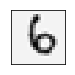

this should be 6


In [32]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print("this should be {}".format(y[pick_one]))

In [37]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100) # 100*400
    sample_images = X[sample_idx, :]
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True,figsize=(8,8))
    
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                  cmap=matplotlib.cm.binary)
            #绘图函数，画100张图片
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

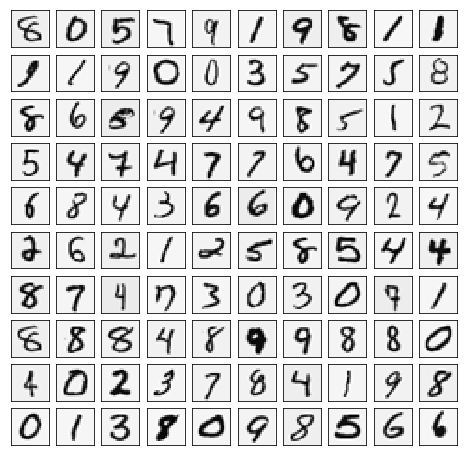

In [39]:
plot_100_image(X)
plt.show()

In [40]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


# 准备数据

In [45]:
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
print(X.shape)
print(X)

(5000, 401)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [44]:
# y have 10 categories here. 1..10, they represent digit 0 as category 10 because matlab index start at 1
# I'll ditit 0, index 0 again
y_matrix = []
for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))
# last one is k==10, it's digit 0, bring it to the first position，最后一列k=10，都是0，把最后一列放到第一列
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)
print(y.shape)
print(y)

(10, 5000)
[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]]


In [46]:
def sigmoid(z):
    return 1/ (1+np.exp(-z))

In [47]:
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1/len(X)) * X.T @ (sigmoid(X @ theta) -y)

In [48]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1-y) * np.log(1-sigmoid(X @ theta)))

In [49]:
def regularized_cost(theta, X, y, l=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l/(2*len(X))) * np.power(theta_j1_to_n, 2).sum()
    return cost(theta, X, y) + regularized_term

In [51]:
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l/len(X)) * theta_j1_to_n
    regularized_term = np.concatenate(
    [np.array([0]), regularized_theta]
    )
    return gradient(theta, X, y) + regularized_term

In [57]:
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    theta = np.zeros(X.shape[1])
    
    res = opt.minimize(
        fun=regularized_cost,
        x0=theta,
        args=(X,y,l),
        method='TNC',
        jac=regularized_gradient,
        options={'disp':True}
    )
    final_theta = res.x
    return final_theta

In [53]:
def predict(X, theta):
    prob = sigmoid(X @ theta)
    return (prob >= 0.5).astype(int)

In [58]:
t0 = logistic_regression(X, y[0])

In [61]:
print(t0.shape)
y_pred = predict(X, t0)
print('Accuracy={}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy=0.9974


# train k model(训练k维模型)

In [62]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
print(k_theta.shape)

(10, 401)


# 进行预测
* think about the shape of k_theta, now you are making $X\times\theta^T$
> $(5000, 401) \times (10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [63]:
prob_matrix = sigmoid(X @ k_theta.T)

In [65]:
np.set_printoptions(suppress=True)
prob_matrix

array([[0.99577201, 0.        , 0.00053527, ..., 0.0000647 , 0.00003907,
        0.00172396],
       [0.99834516, 0.0000001 , 0.0000561 , ..., 0.00009699, 0.0000029 ,
        0.00008493],
       [0.99139498, 0.        , 0.00056786, ..., 0.00000655, 0.02654367,
        0.00197666],
       ...,
       [0.00000068, 0.04142977, 0.00321122, ..., 0.00012713, 0.00297146,
        0.70759742],
       [0.00001844, 0.00000013, 0.00000009, ..., 0.00164803, 0.0682206 ,
        0.86121005],
       [0.0288402 , 0.        , 0.00012978, ..., 0.36640368, 0.00497676,
        0.14838968]])

In [71]:
y_pred = np.argmax(prob_matrix, axis=1)#返回沿轴axis最大值的索引，axis=1代表行
y_pred

array([0, 0, 0, ..., 9, 9, 7])

In [73]:
y_answer = raw_y.copy()
y_answer[y_answer==10] = 0
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

   micro avg       0.94      0.94      0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 神经网络模型图示
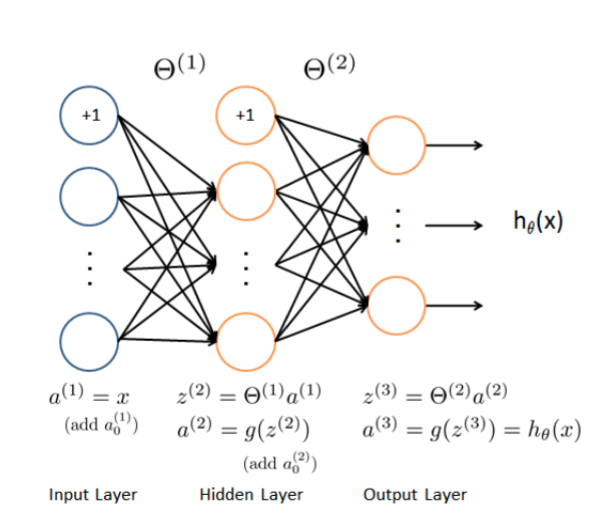

In [76]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [78]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

 因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [79]:
X, y = load_data('ex3data1.mat', transpose=False)
X = np.insert(X, 0 ,values=np.ones(X.shape[0]), axis=1)
X.shape, y.shape

((5000, 401), (5000,))

# feed forward prediction（前馈预测）

In [80]:
a1 = X

In [83]:
z2 = a1 @ theta1.T
z2.shape

(5000, 25)

In [85]:
z2 = np.insert(z2, 0, values=np.ones(z2.shape[0]), axis=1)

In [86]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [88]:
z3 = a2 @ theta2.T
a3 = sigmoid(z3)
z3, a3

(array([[ -8.88634451,  -6.1852269 ,  -5.79281204, ...,  -7.61853965,
          -4.85315933,   5.57675909],
        [ -7.43860951,  -5.85748892,  -5.48124367, ...,  -5.83217892,
          -6.04836016,   5.56806726],
        [ -9.12696081,  -5.56194518,  -3.4561658 , ...,  -2.51021171,
          -5.01858918,   2.68044402],
        ...,
        [ -2.70323947,  -5.39826077,  -3.30350647, ...,  -5.93558797,
           0.79754068, -10.5035926 ],
        [ -6.88782819,  -7.21577627,  -7.87876078, ...,  -4.21469466,
           3.70497161,  -8.36263286],
        [ -9.73654711,  -7.52022374, -10.56136406, ...,  -4.95408951,
           1.00895021,  -2.29341731]]),
 array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
         0.99622946],
        [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
         0.99619667],
        [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
         0.93586278],
        ...,
        [0.06278247, 0.00450406, 0.0

In [89]:
y_pred = np.argmax(a3, axis=1) + 1
y_pred.shape

(5000,)

# 准确率
 
虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。

In [90]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

   micro avg       0.98      0.98      0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

